In [73]:
!pip install seaborn

  Using cached Pillow-8.2.0-cp38-cp38-win_amd64.whl (2.2 MB)


# 0.0 IMPORTS

In [85]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display  import HTML
from IPython.display       import Image

## 0.1 Helper Functions

In [76]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [81]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
# loading datasets

df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merging datasets

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 DESCRIÇÃO DOS DADOS

In [46]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [47]:
# original name of the columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# using inflection to create the new cols

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

# renaming the cols

df1.columns = cols_new

## 1.2 - Data Dimension

In [48]:
# dataset's size

print(f'Number of rows:\t\t {df1.shape[0]}')
print(f'Number of columns:\t {df1.shape[1]}')

Number of rows:		 1017209
Number of columns:	 18


## 1.3 - Data Types

In [49]:
# transforming date to datetime

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NAs

In [50]:
df1.isna().sum().sort_values()

store                                0
promo2                               0
assortment                           0
store_type                           0
state_holiday                        0
promo                                0
school_holiday                       0
customers                            0
sales                                0
date                                 0
day_of_week                          0
open                                 0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2_since_year               508031
promo2_since_week               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill Out NAs

In [51]:
# competition_distance

max_value = df1['competition_distance'].max()

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_value * 2 if math.isnan(x) else x)

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year 

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week  

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval           

month_map = {1:'Jan',
             2:'Feb',
             3:'Mar',
             4:'Apr',
             5:'Mai',
             6:'Jun',
             7:'Jul',
             8:'Aug',
             9:'Sep',
             10:'Oct',
             11:'Nov',
             12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [55]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [57]:
# changing the variable type from float to int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

Serve para duas coisas: 1 ganhar conhecimento de negocios, e a segunda é para a detecção de alguns erros. Existem duas grandes métricas. Disperção e tendencia central. 

Tendencia Central resumem os dados em um único número, exemplo média, mediana e etc.
As medidas de disperção irão nos mostram o quão exparso os dados estão dessas medidas, para mnostrar o quão distante ou proximo os dados estão das medias.

skew fala a deformação da distribuição normal, esquerda positiva, direita negativa

kurtosi quanto maior a curtosi a pico é alto, menor o pico curtosi negativa e dados dispersos.

In [61]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [62]:
num_att = df1.select_dtypes(include = ['int32', 'int64', 'float64'])

cat_att = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Nummerical Attributes

In [70]:
# central tendency - mean, median

ct1 = pd.DataFrame(num_att.apply(np.mean)).T

ct2 = pd.DataFrame(num_att.apply(np.median)).T

# dispersion - standard deviation, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_att.apply(np.std)).T

d2 = pd.DataFrame(num_att.apply(min)).T

d3 = pd.DataFrame(num_att.apply(max)).T

d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T

d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat((d2, d3, d4, ct1, ct2, d1, d5, d6)).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

In [71]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,151720.0,151700.0,5810.044888,2330.0,10715.007635,7.593832,90.447876
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


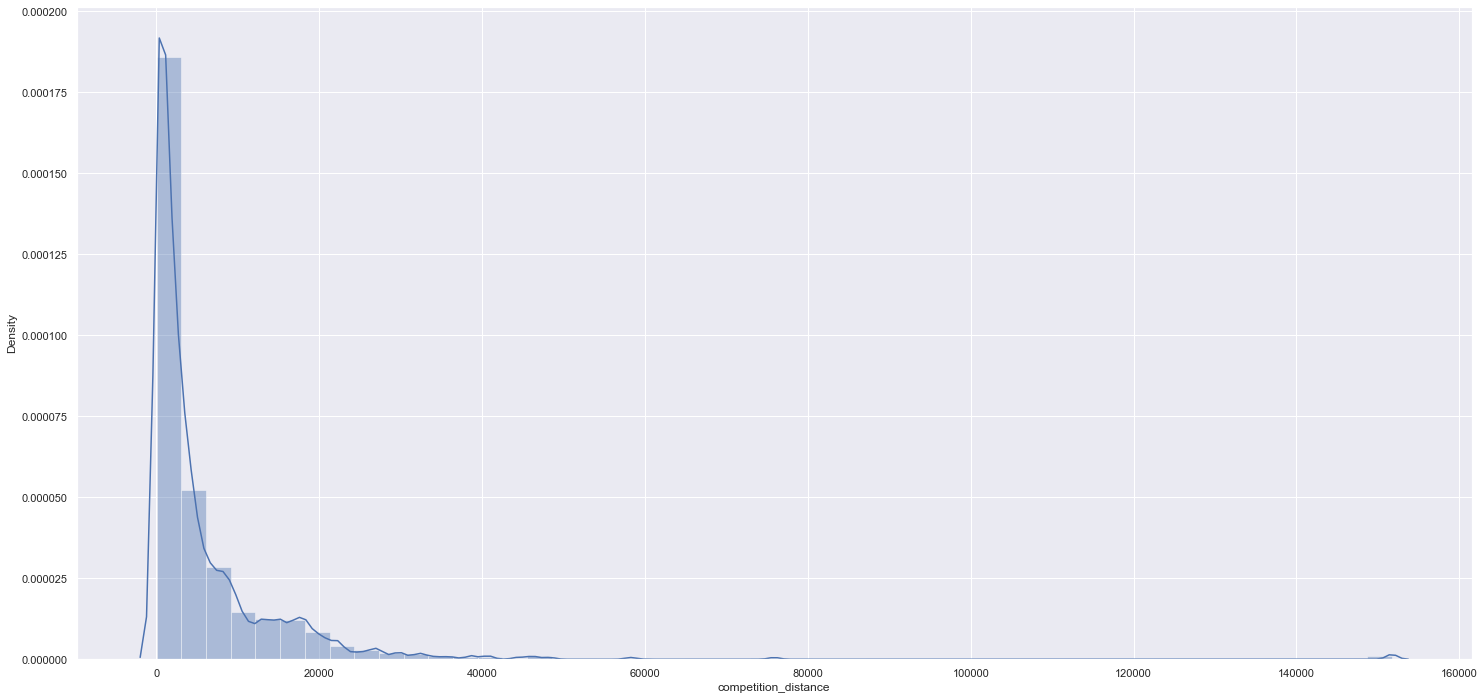

In [87]:
sns.distplot(df1['competition_distance']);

### 1.7.2 - Categorical Attributes

In [88]:
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

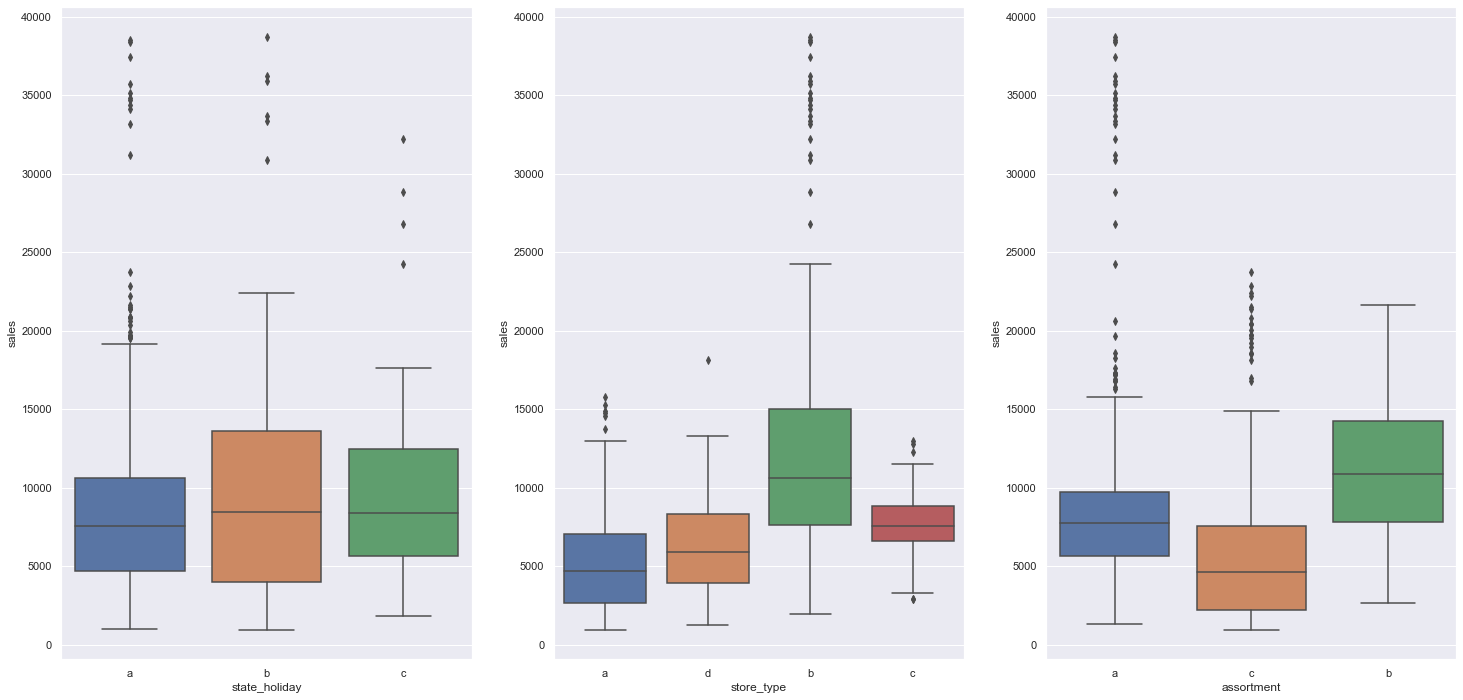

In [94]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);

# 2.0 FEATURE ENGINEERING

In [96]:
df2 = df1.copy()

## 2.1 Mindmap Hyphotesis

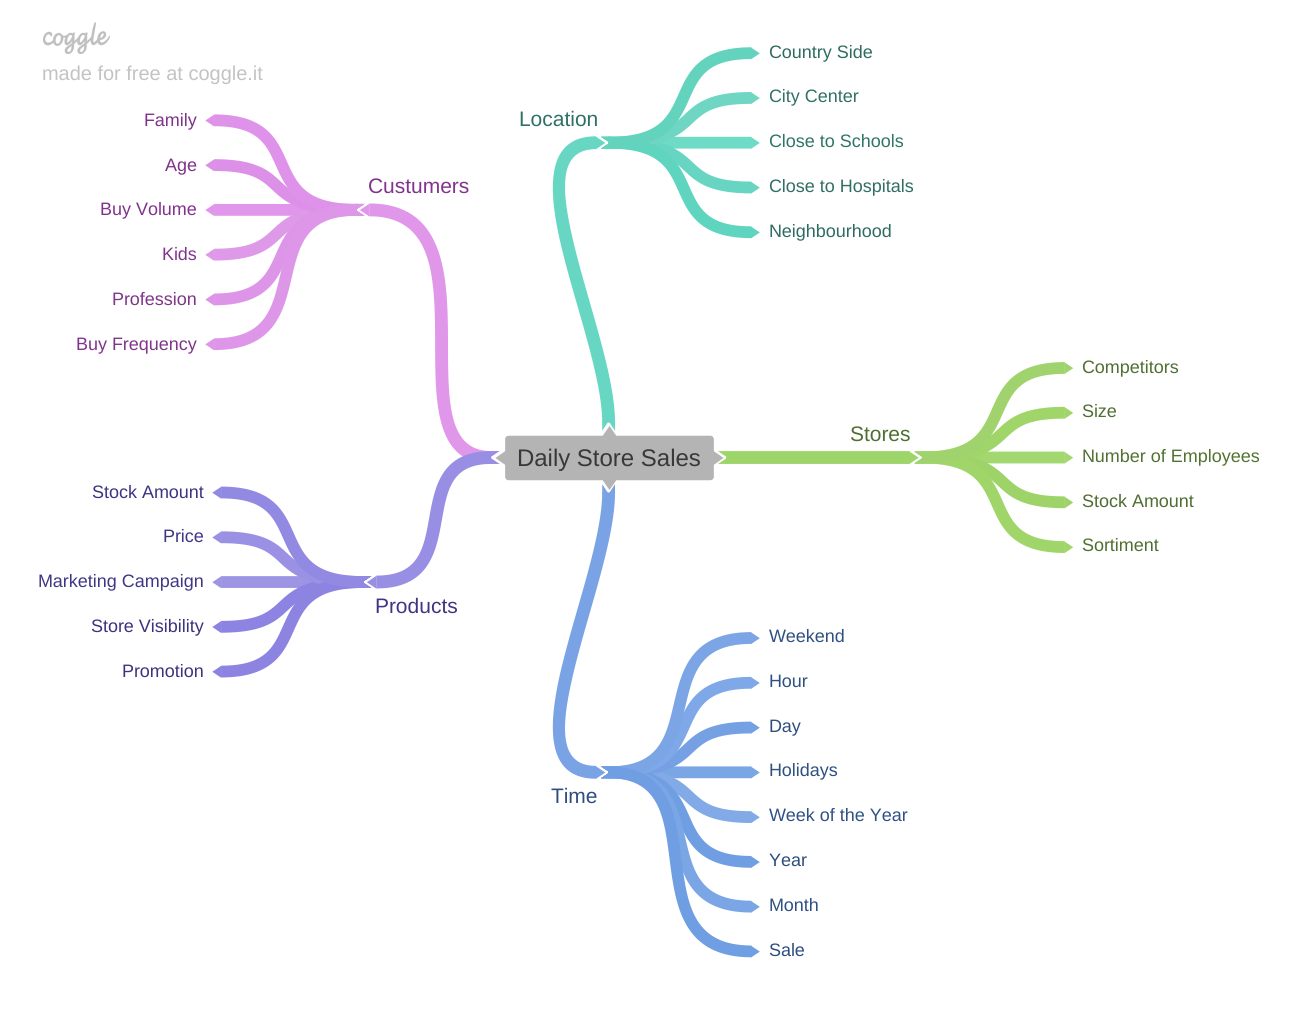

In [95]:
Image('img/mental_map.png')

## 2.2 Hyphotesis Creation

### 2.2.1 - Store's Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 - Products's Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 - Time's Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Final List of Hyphotesis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [101]:
# year

df2['year'] = df2['date'].dt.year

# month

df2['month'] = df2['date'].dt.month

# day

df2['day'] = df2['date'].dt.day

# week_of_year

df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week

df2['week_of_year'] = df2['date'].dt.strftime('%Y-%W')

# competition_since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo_since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [102]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 0.0 IMPORTS